In [44]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
 
stop_words = set(stopwords.words('english'))

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import f1_score, make_scorer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder

# Load dataset
df = pd.read_csv("/Users/kirillkonca/Documents/dementia_prediction/data.csv")

tasks = {
    "MCI vs. AD": df[df['diagnosis'].isin(['MCI', 'AD'])],
    "MCI vs. Control": df[df['diagnosis'].isin(['MCI', 'Control'])],
    "MCI vs. AD vs. Control": df
}

models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
    "SVM": SVC(kernel="sigmoid", random_state=42, class_weight='balanced'),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
}

kf = KFold(n_splits=10, shuffle=True, random_state=42)
f1_scorer = make_scorer(f1_score, average="macro")

ngram_ranges = [(1, 1), (1, 2), (1, 3), (2, 2), (2, 3), (3,3)]  # Different ngram ranges to test

results = []

for task_name, task_df in tasks.items():
    print(f"\n### {task_name} ###\n")
    X = task_df['speech']
    y = LabelEncoder().fit_transform(task_df['diagnosis'])
    
    for model_name, model in models.items():
        print(f"\nModel: {model_name}")
        
        best_ngram = None
        best_score = 0
        
        for ngram_range in ngram_ranges:
            print(f"\nTesting ngram_range: {ngram_range}")
            pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(ngram_range=ngram_range, max_features=5000, stop_words=stop_words)),
                ('clf', model)
            ])
            scores = cross_val_score(pipeline, X, y, cv=kf, scoring=f1_scorer)
            mean_score = scores.mean()
            
            print(f"F1-Macro for {model_name} with ngram {ngram_range}: {mean_score:.4f}")
            
            if mean_score > best_score:
                best_score = mean_score
                best_ngram = ngram_range
        
        print(f"\nBest ngram_range for {model_name} on {task_name}: {best_ngram} with F1-Macro: {best_score:.4f}\n")
        
        final_pipeline = Pipeline([
            ('tfidf', TfidfVectorizer(ngram_range=best_ngram, max_features=5000, stop_words=stop_words)),
            ('clf', model)
        ])
        final_scores = cross_val_score(final_pipeline, X, y, cv=kf, scoring=f1_scorer)
        
        results.append({
            "Task": task_name,
            "Model": model_name,
            "Best ngram_range": best_ngram,
            "Mean F1 Macro": final_scores.mean(),
            "Std F1": final_scores.std(),
        })



### MCI vs. AD ###


Model: Random Forest

Testing ngram_range: (1, 1)
F1-Macro for Random Forest with ngram (1, 1): 0.4614

Testing ngram_range: (1, 2)
F1-Macro for Random Forest with ngram (1, 2): 0.4614

Testing ngram_range: (1, 3)
F1-Macro for Random Forest with ngram (1, 3): 0.4614

Testing ngram_range: (2, 2)
F1-Macro for Random Forest with ngram (2, 2): 0.4614

Testing ngram_range: (2, 3)
F1-Macro for Random Forest with ngram (2, 3): 0.4614

Testing ngram_range: (3, 3)
F1-Macro for Random Forest with ngram (3, 3): 0.4614

Best ngram_range for Random Forest on MCI vs. AD: (1, 1) with F1-Macro: 0.4614


Model: SVM

Testing ngram_range: (1, 1)
F1-Macro for SVM with ngram (1, 1): 0.6678

Testing ngram_range: (1, 2)
F1-Macro for SVM with ngram (1, 2): 0.7030

Testing ngram_range: (1, 3)
F1-Macro for SVM with ngram (1, 3): 0.6763

Testing ngram_range: (2, 2)
F1-Macro for SVM with ngram (2, 2): 0.6448

Testing ngram_range: (2, 3)
F1-Macro for SVM with ngram (2, 3): 0.6548

Testing ngr

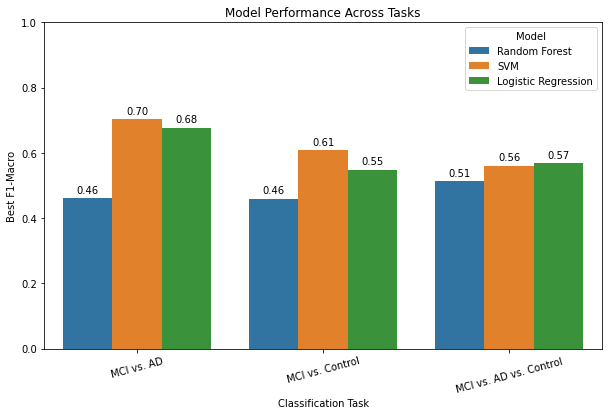

In [46]:
results_df = pd.DataFrame(results)

plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=results_df,
    x="Task",
    y="Mean F1 Macro",
    hue="Model",
    capsize=0.1,
    errwidth=1.5
)

plt.ylim(0, 1)
plt.ylabel("Best F1-Macro")
plt.xlabel("Classification Task")
plt.title("Model Performance Across Tasks")
plt.xticks(rotation=15)
plt.legend(title="Model")

# Add labels to bars
for container in ax.containers:
    ax.bar_label(container, fmt="%.2f", padding=3)

plt.show()

In [133]:
import pandas as pd
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.preprocessing import LabelEncoder

class TextSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key): self.key = key
    def fit(self, X, y=None): return self
    def transform(self, X): return X[self.key].values  # Convert to 1D array

class NumberSelector(BaseEstimator, TransformerMixin):
    def __init__(self, keys): self.keys = keys
    def fit(self, X, y=None): return self
    def transform(self, X): return X[self.keys]  # Keep multiple numerical columns as DataFrame

df = pd.read_csv("/Users/kirillkonca/Documents/dementia_prediction/data.csv")

X = df[['speech'] + numerical_features]  # Speech (text) + Multiple numerical features
y = LabelEncoder().fit_transform(df['diagnosis'])  # Encode labels

feature_union = FeatureUnion([
    ('text_features', Pipeline([
        ('selector', TextSelector('speech')), 
        ('tfidf', TfidfVectorizer(ngram_range=(1, 3), max_features=5000))
    ])),
    ('numerical_features', Pipeline([
        ('selector', NumberSelector(numerical_features)), 
        ('scaler', StandardScaler())  # Scale all numerical features together
    ]))
])

svm_model = SVC(random_state=42, class_weight='balanced')

pipeline = Pipeline([
    ('features', feature_union),  # Process text and numerical features separately
    ('clf', svm_model)  # Classification model
])

param_grid = {
    'clf__C': [0.1, 1, 10],
    'clf__kernel': ['linear', 'rbf', 'sigmoid'],
    'clf__gamma': ['scale', 'auto']
}

kf = KFold(n_splits=10, shuffle=True, random_state=42)

grid_search = GridSearchCV(pipeline, param_grid, cv=kf, scoring='f1_macro', n_jobs=-1)
grid_search.fit(X, y)

print("Best parameters:", grid_search.best_params_)
print("Best F1-macro score:", grid_search.best_score_)


Best parameters: {'clf__C': 10, 'clf__gamma': 'scale', 'clf__kernel': 'linear'}
Best F1-macro score: 0.5490487900289432
